# Molecules

A molecular or chemical graph is a structural representation of molecule in which atoms are nodes and chemical bonds define the edges of the graph. 

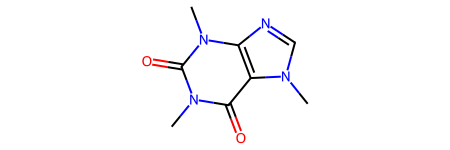

In [1]:
import rdkit.Chem as Chem
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")

A chemical structure can be depicted in 2D with chemiformatics software such as [`RDKit`](https://www.rdkit.org/) or [`OpenBabel`](https://www.rdkit.org/). Both have similar class definitions of molecules, atoms and bonds classes and provide a large scope of methods to work with molecular structures.

In `kgcnn.mol.base` a general interface `MolGraphInterface` is defined that should unify access to the chemical graph used for deep learning models. Both `RDKit` and `OpenBabel` can be used as backend (Note that `OpenBabel` must be installed manually since no complete pypi installation is yet available). 

In [2]:
from kgcnn.molecule.graph_rdkit import MolecularGraphRDKit
from kgcnn.molecule.graph_babel import MolecularGraphOpenBabel

Main operations to generate a molecular graph from e.g. smiles or mol-tables as well as generating and optimizting conformation or compute charges are methods of the interface and can be used with both `RDKit` or `OpenBabel` backend. Specific kwargs for those methods, however, are handed to the specific functions of the backend and therefore require knowledge about the paramters of the backend.

In [3]:
mg = MolecularGraphRDKit(make_directed=False)
mg.from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
mg.add_hs()
mg.make_conformer()
mg.optimize_conformer(force_field="mmff94")
mg.compute_partial_charges(method="gasteiger")

Note that the actual Mol-Class not privaate and accessible via `mol` .

In [4]:
str(mg.mol)

'<rdkit.Chem.rdchem.Mol object at 0x0000022D2F04A2D0>'

Most importantly are methods to generate graph properties from the mol-object. In the example below are node and edge types or numbers, for the first 4 atoms or bonds, respectively:

In [5]:
mg.edge_indices[:4], mg.node_symbol[:4], mg.node_coordinates[:4], mg.edge_number[1][:4]  # Indices and bond order

(array([[ 0,  1],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16]], dtype=int64),
 ['C', 'N', 'C', 'N'],
 array([[ 3.26735076,  0.61278444, -0.2364124 ],
        [ 2.1264268 , -0.26661905, -0.26747634],
        [ 2.15131889, -1.61634095, -0.50052716],
        [ 0.94130742, -2.13852225, -0.46338622]]),
 [1, 1, 1, 1])

For attributed graphs a feature vector for atoms, bonds and the total graph has been found to improve GNNs. The functions of the interface `node_attributes` , `edge_attributes` and `graph_attributes` and take a list of strings (predifined) or functions for each attributes. Here are the list of attributes for `RDKit` by name:

In [6]:
MolecularGraphRDKit.atom_fun_dict.keys()

dict_keys(['NumBonds', 'AtomicNum', 'AtomMapNum', 'Idx', 'Degree', 'TotalDegree', 'Symbol', 'NumExplicitHs', 'NumImplicitHs', 'TotalNumHs', 'IsAromatic', 'Isotope', 'TotalValence', 'Mass', 'MassScaled', 'IsInRing', 'Hybridization', 'NoImplicit', 'ChiralTag', 'FormalCharge', 'ExplicitValence', 'ImplicitValence', 'NumRadicalElectrons', 'HasOwningMol', 'PDBResidueInfo', 'MonomerInfo', 'Smarts', 'CIPCode', 'CIPRank', 'ChiralityPossible', 'MolFileRLabel', 'GasteigerCharge', 'GasteigerHCharge', 'AtomFeatures', 'DescribeQuery', 'Rvdw', 'RvdwScaled', 'Rcovalent', 'RcovalentScaled'])

In [7]:
MolecularGraphRDKit.bond_fun_dict.keys()

dict_keys(['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo', 'Idx', 'BeginAtom', 'BeginAtomIdx', 'BondDir', 'BondTypeAsDouble', 'EndAtom', 'EndAtomIdx', 'Smarts', 'DescribeQuery'])

In [8]:
MolecularGraphRDKit.mol_fun_dict.keys()

dict_keys(['C', 'N', 'O', 'H', 'S', 'F', 'Cl', 'NumAtoms', 'AtomsIsInRing', 'AtomsIsAromatic', 'NumBonds', 'BondsIsConjugated', 'BondsIsAromatic', 'NumRotatableBonds', 'ExactMolWt', 'FpDensityMorgan3', 'FractionCSP3', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Ar_COO', 'fr_Al_OH', 'fr_Ar_OH', 'fr_C_O_noCOO', 'fr_NH2', 'fr_SH', 'fr_sulfide', 'fr_alkyl_halide'])

Then node attributes for the molecular graph can be generated from a list of attribute names.

In [9]:
mg.node_attributes(["NumBonds", "Mass", "Symbol", "IsInRing", "GasteigerCharge"], encoder={})[:4]

[[4, 12.011, 'C', False, '0.012958350519987684'],
 [3, 14.007, 'N', True, '-0.32786346609948208'],
 [3, 12.011, 'C', True, '0.097502273308341464'],
 [2, 14.007, 'N', True, '-0.21837692759548705']]

In order to have all features of a number data type an encoder can be added for each named feature:

In [10]:
from kgcnn.molecule.encoder import OneHotEncoder
mg.node_attributes(["NumBonds", "Mass", "Symbol", "IsInRing", "GasteigerCharge"], 
                   encoder={"Symbol": OneHotEncoder(["C", "O", "N", "H"], dtype="str"), "GasteigerCharge": float})[:4]

[[4, 12.011, 1, 0, 0, 0, 0, False, 0.012958350519987684],
 [3, 14.007, 0, 0, 1, 0, 0, True, -0.3278634660994821],
 [3, 12.011, 1, 0, 0, 0, 0, True, 0.09750227330834146],
 [2, 14.007, 0, 0, 1, 0, 0, True, -0.21837692759548705]]

If a feature is not in the list of named attributes, a function can be inserted in place. Note that the function should always return a single value or a list of values. Argument will be the bond, molecule or atom class of the backend, respectively.

In [11]:
def mol_feature(atom):
    # Note that you can also get the mol object with e.g.
    # mol = atom.GetOwningMol()
    return atom.GetAtomicNum()

mg.node_attributes([mol_feature], encoder={})[:4]

[[6], [7], [6], [7]]

The dataset `MoleculeNetDataset` uses the `MolGraphInterface` in `map_molecule_callbacks` , which specifies the used interface within `mol_interface_class` .

### Training example

Example with ESOLDataset.

In [12]:
%%capture
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
data = ESOLDataset()

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name ESOL
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.ESOL:Found SDF C:\Users\patri\.kgcnn\datasets\ESOL\delaney-processed.sdf of pre-computed structures.
INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None, 'S', 'R'

The above descriptors can be passed to Molecule datasets via the `read_in_memory` or `set_attributes method`.

In [13]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    add_hydrogen=False,
    make_directed=False,
    has_conformers=True,
    sanitize=True,
    compute_partial_charges=None,
    label_column_name="measured log solubility in mols per litre"
)

INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None, 'S', 'R']
INFO:kgcnn.molecule.encoder:OneHotEncoder ChiralityPossible found [None, '1']
INFO:kgcnn.molecule.encoder:OneHotEncoder BondType found [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC, rdkit.Chem.rdchem.BondType.DOUBLE]
INFO:kgcnn.molecule.encoder:OneHotEncoder Stereo found [rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Che

Additional attributes and tensor properties can be generated with graph preprocessors. 
Note that there is also a graph preprocessor in `kgcnn.molecule.preprocessor` apart from `MoleculeNetDataset` .

In [14]:
from kgcnn.graph.preprocessor import SetRange, SetEdgeIndicesReverse
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(SetEdgeIndicesReverse(in_place=True));
data.map_list(method="count_nodes_and_edges");

In [15]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'edge_indices_reverse', 'total_nodes', 'total_edges'])

In [16]:
data.clean("edge_indices")

INFO:kgcnn.data.ESOL:Property 'edge_indices' is an empty list for graph '934'.


array([934])

Prepare graph labels

In [17]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

Train test indices with e.g. KFold.

In [18]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [19]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.GIN",
    "config": {
        "name": "GIN",
        "inputs": [
            {"shape": [None, 41], "name": "node_attributes", "dtype": "float32"},
            {"shape": [None, 2], "name": "edge_indices", "dtype": "int64"},
            {"shape": (), "name": "total_nodes", "dtype": "int64"},
            {"shape": (), "name": "total_edges", "dtype": "int64"}
        ],
        "verbose": 50,
        "cast_disjoint_kwargs": {"padded_disjoint": False},
        "input_node_embedding": {"input_dim": 96, "output_dim": 64},
        "depth": 5,
        "dropout": 0.05,
        "gin_mlp": {"units": [64, 64], "use_bias": True, "activation": ["relu", "linear"],
                    "use_normalization": True, "normalization_technique": "graph_batch",
                    "padded_disjoint": False},
        "gin_args": {},
        "last_mlp": {"use_bias": True, "units": [64, 32, 1], "activation": ["relu", "relu", "linear"]},
        "output_embedding": "graph",
        "output_mlp": {"activation": "linear", "units": 1}
    }
}

In [20]:
%%capture
import time
from kgcnn.models.utils import get_model_class
from keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.GIN import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = StandardLabelScaler(with_std=True,with_mean=True, copy=True)
    scaler.fit(y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(learning_rate=5e-04))

    # Build model with reasonable data.
    model.predict(x_test, batch_size=2, steps=2)
    model._compile_metrics.build(y_test, y_test)
    model._compile_loss.build(y_test, y_test)

    # Model summary
    model.summary()
    print(" Compiled with jit: %s" % model._jit_compile)  # noqa
    print(" Model is built: %s, with unbuilt: %s" % (
        all([layer.built for layer in model._flatten_layers()]),  # noqa
        [layer.name for layer in model._flatten_layers() if not layer.built]
    ))

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=300, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=0,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

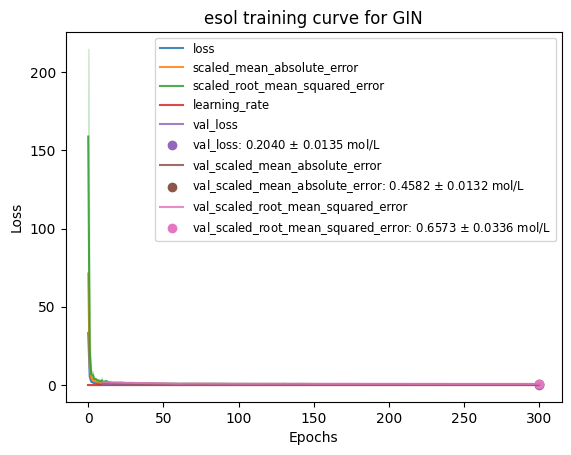

In [21]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="GIN", data_unit="mol/L", dataset_name="esol",
                     filepath="", file_name=f"loss.png");

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


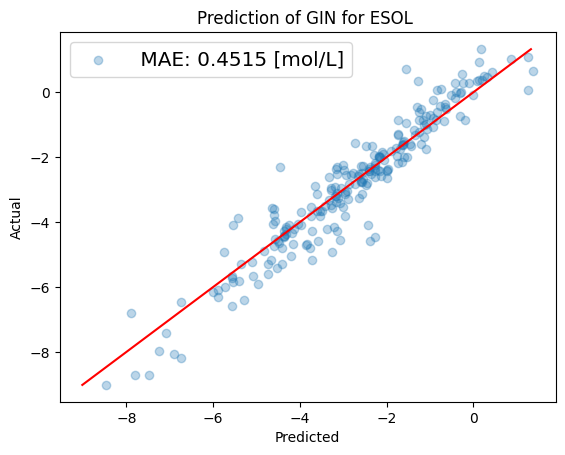

In [22]:
# Plot prediction for the last split.
predicted_y = model.predict(x_test)
true_y = y_test

# Predictions must be rescaled to original values.
predicted_y = scaler.inverse_transform(predicted_y)
true_y = scaler.inverse_transform(true_y)

# Plotting the prediction vs. true test targets for last split. Note for classification this is also done but
# can be ignored.
plot_predict_true(predicted_y, true_y,
                  filepath="", data_unit="mol/L",
                  model_name="GIN", dataset_name="ESOL",
                  file_name=f"predict.png");

> **NOTE**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/docs/source